In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm
import json

In [2]:
# Source: https://docs.google.com/spreadsheets/d/1yZv9w9zRKwrGTaR-YzmAqMefw4wMlaXocejdxZaTs6w/htmlview?sle=true

In [3]:
df = pd.read_csv('input/confirmed.csv', sep=';')

In [4]:
df.tail()

,date,confirmed
8,2020-01-28,6087
9,2020-01-29,7888
10,2020-01-30,9776
11,2020-01-31,11374
12,2020-02-01,14554


In [5]:
model = pm.auto_arima(
    df['confirmed'],
    test='kpss',
    seasonal=False,
    error_action='ignore',  
    suppress_warnings=True
)

In [6]:
n_periods = 4

In [7]:
forecast, bounds = model.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)

In [8]:
df_pred = pd.DataFrame([], index=range(len(df)+n_periods))
dates = pd.date_range(start=pd.to_datetime(df['date']).min(), periods=len(df)+n_periods)
df_pred['labels'] = [dt.strftime("%Y-%m-%d") for dt in dates]
df_pred['confirmed'] = df['confirmed']
last_confirmed = df['confirmed'].values[-1]
df_pred['forecast'] = [*([None] * (len(df)-1)), last_confirmed, *forecast]
df_pred['lower'] = [*([None] * (len(df)-1)), last_confirmed,  *bounds[:, 0]]
df_pred['upper'] = [*([None] * (len(df)-1)), last_confirmed,  *bounds[:, 1]]

for col in df_pred.dtypes[df_pred.dtypes == 'float64'].index:
    df_pred[col] = df_pred[col].apply(lambda v: int(v) if pd.notnull(v) else v)

df_pred

,labels,confirmed,forecast,lower,upper
0,2020-01-20,282.0,NaN,NaN,NaN
1,2020-01-21,332.0,NaN,NaN,NaN
2,2020-01-22,555.0,NaN,NaN,NaN
3,2020-01-23,653.0,NaN,NaN,NaN
4,2020-01-24,941.0,NaN,NaN,NaN
5,2020-01-25,2040.0,NaN,NaN,NaN
6,2020-01-26,2757.0,NaN,NaN,NaN
7,2020-01-27,4465.0,NaN,NaN,NaN
8,2020-01-28,6087.0,NaN,NaN,NaN
9,2020-01-29,7888.0,NaN,NaN,NaN


In [9]:
d = df_pred.to_dict(orient='list')

for k in d.keys():
    d[k] = [v if pd.notnull(v) else None for v in d[k]]

with open('../js/results.json', 'w') as fp:
    json.dump(d, fp)

In [10]:
import matplotlib.pyplot as plt

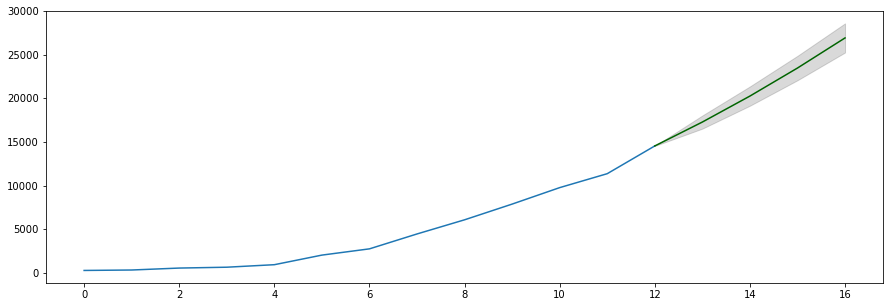

In [11]:
index = df_pred.index

fc_series = pd.Series(index, index=index)
lower_series = pd.Series(df_pred['lower'], index=index)
upper_series = pd.Series(df_pred['upper'], index=index)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(df_pred['confirmed'])
plt.plot(df_pred['forecast'], color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.show()
